In [1]:
# imports and functions, does nothing

from IPython.display import Image
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from json import JSONEncoder
import json

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def serialize(uri, o, version=''):
    try:
        os.remove(".cache/"+uri)
    except:
        pass
    with open(".cache/"+uri, "w") as f:
        if version != '':
            f.write('#version: '+version+'\n')
        json.dump(o, f, cls=NumpyArrayEncoder)

def deserialize(uri, version=''):
    if os.path.isfile(".cache/"+uri):
        with open(".cache/"+uri, "r") as f:
            data = []
            for line in f:
                if not line.startswith('#version:'):
                    data.append(line)
            return json.loads(''.join(data))
    return None

def load_or_compute(uri, compute_function, rebuild=False):
    data = None
    if not rebuild:
        data = deserialize(uri)
    if data is None:
        data = compute_function()
        serialize(uri, data)
        return data
    return data

def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""

def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()

In [2]:
data_all = np.load('datasets/quic-100p-150-40runs.npy', allow_pickle=True).item()
data = data_all['nofilter'] # adblock + decentraleyes
urls = [url for url in data]

# total incoming size
def add(a, b):
    x = 0
    if a is not None:
        x += abs(a)
    if b is not None:
        x += abs(b)
    return x

def toOldHARFormat(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
                data2[url][sample].append([t, add(out_h, out_b), add(inc_h, inc_b)])
    return data2


data_notimings = {}
for url in data:
    data_notimings[url] = {}
    for sample in data[url]:
        data_notimings[url][sample] = []
        for request in data[url][sample]:
            domain, fullurl, t, out_h, out_b, t_resp, inc_h, inc_b = request
            data_notimings[url][sample].append([domain, fullurl, 0, out_h, out_b, 0, inc_h, inc_b ])


data_old_format = toOldHARFormat(data)
data_old_format_noprotections = toOldHARFormat(data_all['nofilter'])

In [3]:
from lib.features import *
from lib.rf import *

from evaluate_defense import *
from fbleau_utils import *
from lib.features import *

def get_estimate_stats(result):
    
    random_guess = []
    min_estimate = []
    last_estimate = []
    
    for k, v in result.items():
        random_guess.append(v['random-guessing'])
        min_estimate.append(v['min-estimate'])
        last_estimate.append(v['last-estimate'])
        
    return min_estimate, last_estimate, random_guess


Queries: median 14785.0 max 126557 
Responses: median 768172.0 max 9324936 


Text(0, 0.5, 'Total Incoming [B]')

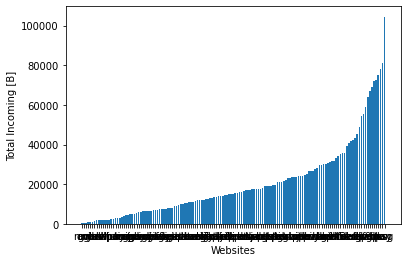

In [5]:
# total incoming size
incoming_bytes = []
incoming_bytes_per_website = dict()
incoming_bytes_per_website_noprotection = dict()

tot_queries = []
tot_responses = []

for url in data_old_format:
    outgoing_bytes_this_website = []

    for sample in data_old_format[url]:
        query = 0
        response = 0

        outgoing_bytes_this_sample = 0
        for request in data_old_format[url][sample]:
            t, out, inc = request
            outgoing_bytes_this_sample += out
            query += out
            response += inc
            incoming_bytes.append(inc)

        tot_queries.append(query)
        tot_responses.append(response)
        outgoing_bytes_this_website.append(outgoing_bytes_this_sample)

    if len(outgoing_bytes_this_website) > 0:
        incoming_bytes_per_website[url] = [np.mean(outgoing_bytes_this_website), np.std(outgoing_bytes_this_website)]


print(f"Queries: median {np.median(tot_queries)} max {np.max(tot_queries)} ")
print(f"Responses: median {np.median(tot_responses)} max {np.max(tot_responses)} ")

tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]

plt.bar(np.arange(len(ys)), ys)
plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Incoming [B]')
#plt.yscale('log')
#plt.ylim([0, 10000])

Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123
[feature_extract] Number of features 12

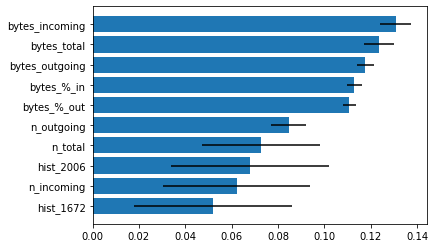

In [6]:
#baseline on HARs

np.save("fbleau/7.3.2_baseline_har.npy", data)
np.save("fbleau/7.3.2_baseline_har_notiming.npy", data_notimings)
features = get_features(data_old_format)
clf_res = rf_with_rfe(features, n_classes=141)
print(clf_res)
plot_fi(clf_res['features'], title="")

In [7]:
# Fbleau

result = analyze_dataset(features)
min_estimate, last_estimate, random_guess = get_estimate_stats(result)
print("\nOverall stats:")
print("Min estimate:", "Mean", np.mean(min_estimate), "Std", np.std(min_estimate))
print("Last estimate:", "Mean", np.mean(last_estimate), "Std", np.std(last_estimate))
print("Random guess estimate:", "Mean", np.mean(random_guess), "Std", np.std(random_guess))

F-BLEAU Result for fold 1 {'min-estimate': 0.24831568816169394, 'last-estimate': 0.24831568816169394, 'random-guessing': 0.9903753609239654, 'estimates': [], 'min-individual-errors': []}
F-BLEAU Result for fold 2 {'min-estimate': 0.2685274302213667, 'last-estimate': 0.2685274302213667, 'random-guessing': 0.9903753609239654, 'estimates': [], 'min-individual-errors': []}

Overall stats:
Min estimate: Mean 0.2584215591915303 Std 0.010105871029836386
Last estimate: Mean 0.2584215591915303 Std 0.010105871029836386
Random guess estimate: Mean 0.9903753609239654 Std 0.0


Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 123
[feature_extract] Number of features 12

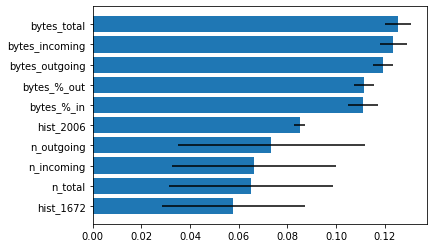

F-BLEAU Result for fold 1 {'min-estimate': 0.24831568816169394, 'last-estimate': 0.24831568816169394, 'random-guessing': 0.9903753609239654, 'estimates': [], 'min-individual-errors': []}
F-BLEAU Result for fold 2 {'min-estimate': 0.2685274302213667, 'last-estimate': 0.2685274302213667, 'random-guessing': 0.9903753609239654, 'estimates': [], 'min-individual-errors': []}

Overall stats:
Min estimate: Mean 0.2584215591915303 Std 0.010105871029836386
Last estimate: Mean 0.2584215591915303 Std 0.010105871029836386
Random guess estimate: Mean 0.9903753609239654 Std 0.0


In [8]:
#without timings

data_no_timings = dict()
for url in data_old_format:
    data_no_timings[url] = dict()
    for sample in data_old_format[url]:
        data_no_timings[url][sample] = []
        for t, out, inc in data_old_format[url][sample]:
            data_no_timings[url][sample].append([0, out, inc])

features = get_features(data_no_timings)
clf_res = rf_with_rfe(features, n_classes=141)
print(clf_res)
plot_fi(clf_res['features'], title="")

# Fbleau

result = analyze_dataset(features)
min_estimate, last_estimate, random_guess = get_estimate_stats(result)
print("\nOverall stats:")
print("Min estimate:", "Mean", np.mean(min_estimate), "Std", np.std(min_estimate))
print("Last estimate:", "Mean", np.mean(last_estimate), "Std", np.std(last_estimate))
print("Random guess estimate:", "Mean", np.mean(random_guess), "Std", np.std(random_guess))

max query 55523
{'ys': [186, 335, 483, 779, 784, 988, 1282, 1868, 1963, 1979, 2015, 2066, 2106, 2106, 2181, 2422, 2890, 2896, 3075, 3672, 3828, 4244, 4269, 4855, 4987, 5044, 5305, 5825, 5871, 6279, 6303, 6422, 6432, 6483, 6717, 6736, 7192, 7584, 7597, 7609, 7612, 7807, 7833, 8102, 8934, 9205, 9422, 9801, 9947, 10332, 10496, 10864, 10890, 10948, 11675, 11906, 11967, 12032, 12069, 12296, 12518, 12869, 13197, 13496, 13546, 13827, 13895, 14212, 14454, 14595, 14819, 15036, 15109, 15372, 15574, 15832, 15977, 16597, 16824, 17023, 17265, 17435, 17451, 17454, 17479, 17516, 18191, 18904, 19249, 19290, 19306, 19364, 19406, 20987, 21022, 21036, 21757, 22119, 22970, 23094, 23436, 23556, 23850, 24141, 24227, 24257, 24554, 24901, 26387, 26492, 26508, 27706, 28261, 29481, 29535, 30087, 30342, 30863, 31055, 31552, 31623, 33359, 34293, 35412, 35722, 35737, 39179, 40597, 41807, 42185, 43173, 45429, 48918, 54395, 55626, 58989, 64151, 66761, 69199, 72073, 72781, 74813, 78110, 81034, 104464], 'ys_err': [217

Text(0, 0.5, 'Total Outgoing [B]')

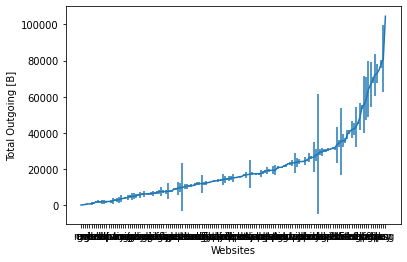

In [6]:
# total outgoing size

max_query = 0

outgoing_bytes_per_website = dict()
outgoing_bytes_per_website2 = dict()

for url in data_old_format:
    outgoing_bytes_this_website = []
    outgoing_bytes_this_website2 = []

    for sample in data_old_format[url]:
        outgoing_bytes_this_sample = 0
        outgoing_bytes_this_sample2 = 0
        for request in data_old_format[url][sample]:
            t, out, inc = request
            outgoing_bytes_this_sample += out
            outgoing_bytes_this_sample2 += 1400
            if out > max_query:
                max_query = out

        outgoing_bytes_this_website.append(outgoing_bytes_this_sample)
        outgoing_bytes_this_website2.append(outgoing_bytes_this_sample2)

    if len(outgoing_bytes_this_website) > 0:
        outgoing_bytes_per_website[url] = [np.mean(outgoing_bytes_this_website), np.std(outgoing_bytes_this_website)]
        outgoing_bytes_per_website2[url] = np.mean(outgoing_bytes_this_website2)

print(f"max query {max_query}")

tuples = list(outgoing_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs = [t[0][:3] for t in tuples]
ys = [int(t[1][0]) for t in tuples]
ys_err = [int(t[1][1]) for t in tuples]

tuples2 = list(outgoing_bytes_per_website2.items())
tuples2.sort(key=lambda row: row[1])
ys2 = [int(t[1]) for t in tuples2]

plot_data = dict(ys=ys, ys_err=ys_err)
print(plot_data)

#plt.bar(np.arange(len(ys)), ys2, label="padded queries")
plt.errorbar(np.arange(len(ys2)), ys, yerr=ys_err, label="standard queries")

plt.xticks(np.arange(len(ys)), xs)
plt.xlabel('Websites')
plt.ylabel('Total Outgoing [B]')
#plt.yscale('log')
#plt.ylim([0, 10000])

In [9]:
# compute optimal padding functions based on incoming sizes

incoming_bytes.sort()
incoming_bytes = [x for x in incoming_bytes if x > 2] # 0 and 1 are special case that correspond to blocked resources

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def find_cost(data, padding_function_steps):
    costs = []
    # data is sorted, so i is never decreasing
    i = 0
    for x in data:
        pad_to = padding_function_steps[i]
        while x > pad_to:
            i += 1
            pad_to = padding_function_steps[i]
        costs.append(pad_to - x)
    return costs


def find_optimal_pad(data, n_cut): # data must be sorted
    size_of_cut = math.ceil(len(data) / n_cut)
    chunked = chunks(data, size_of_cut)
    cuts = [chunk[-1] for chunk in chunked]
    costs = find_cost(data, cuts)

    return cuts, np.median(costs), np.mean(costs)

def build_padding_functions():
    padding_functions = []
    prev_n_cuts = -1
    for cut in range(1, 50):
        cuts, med_cost, mean_cost = find_optimal_pad(incoming_bytes, cut)
        if len(cuts) == prev_n_cuts:
            continue
        prev_n_cuts = len(cuts)
        padding_functions.append([cuts, med_cost, mean_cost])
    return padding_functions

padding_functions = load_or_compute("pad_fn.npy", build_padding_functions, rebuild=True)

for cut, med_cost, mean_cost in padding_functions:
    print(med_cost, cut)


6615527.5 [6625482]
9778.0 [9954, 6625482]
10909.0 [4596, 20874, 6625482]
6136.0 [3068, 9955, 29140, 6625482]
4549.5 [2518, 6226, 16518, 36256, 6625482]
3690.0 [2281, 4596, 9955, 20874, 42208, 6625482]
2878.0 [2156, 3645, 7083, 14218, 23804, 47211, 6625482]
2542.0 [2044, 3068, 5751, 9955, 17429, 29140, 52131, 6625482]
2412.0 [1934, 2743, 4596, 7783, 13154, 20874, 33054, 56882, 6625482]
1935.0 [1829, 2518, 3894, 6226, 9955, 16518, 22934, 36256, 63986, 6625482]
1751.0 [1756, 2401, 3409, 5309, 8168, 12637, 18055, 25434, 38741, 71072, 6625482]
1722.0 [1656, 2281, 3068, 4596, 6690, 9955, 15180, 20874, 29140, 42208, 77886, 6625482]
1539.0 [1588, 2225, 2849, 4055, 5996, 8531, 12283, 17210, 22057, 32090, 43934, 80534, 6625482]
1208.0 [1558, 2156, 2665, 3645, 5162, 7083, 9957, 14219, 18501, 23804, 33798, 47211, 86080, 6625482]
1395.0 [1516, 2093, 2518, 3278, 4596, 6226, 8733, 11971, 16518, 20874, 26347, 36260, 50351, 91554, 6625482]
1074.0 [1490, 2044, 2445, 3068, 4135, 5754, 7476, 9957, 13514,

In [24]:
# compute standard padding functions

def build_padding_functions_cst_block_size(data):
    padding_functions_cst_block_size = []
    for blocksize in np.linspace(100, 100000, 10):

        cuts = []
        cut = 0
        m = max(data)
        while cut < m:
            cut += blocksize
            cuts.append(cut)

        costs = find_cost(data, cuts)
        padding_functions_cst_block_size.append([cuts, np.median(costs), np.mean(costs)])
    return padding_functions_cst_block_size

padding_functions_cst_block_size = load_or_compute("pad_fn_cst_block_size.npy", lambda: build_padding_functions_cst_block_size(incoming_bytes), rebuild=True)

for cuts, med_cost, mean_cost in padding_functions_cst_block_size:
    if med_cost > 0:
        print(med_cost, cuts)
    else:
        print(med_cost, "...")


50.0 [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0, 2900.0, 3000.0, 3100.0, 3200.0, 3300.0, 3400.0, 3500.0, 3600.0, 3700.0, 3800.0, 3900.0, 4000.0, 4100.0, 4200.0, 4300.0, 4400.0, 4500.0, 4600.0, 4700.0, 4800.0, 4900.0, 5000.0, 5100.0, 5200.0, 5300.0, 5400.0, 5500.0, 5600.0, 5700.0, 5800.0, 5900.0, 6000.0, 6100.0, 6200.0, 6300.0, 6400.0, 6500.0, 6600.0, 6700.0, 6800.0, 6900.0, 7000.0, 7100.0, 7200.0, 7300.0, 7400.0, 7500.0, 7600.0, 7700.0, 7800.0, 7900.0, 8000.0, 8100.0, 8200.0, 8300.0, 8400.0, 8500.0, 8600.0, 8700.0, 8800.0, 8900.0, 9000.0, 9100.0, 9200.0, 9300.0, 9400.0, 9500.0, 9600.0, 9700.0, 9800.0, 9900.0, 10000.0, 10100.0, 10200.0, 10300.0, 10400.0, 10500.0, 10600.0, 10700.0, 10800.0, 10900.0, 11000.0, 11100.0, 11200.0, 11300.0, 11400.0, 11500.0, 11600.0, 11700.0, 11800.0, 11900.0, 12000.0, 12100.0, 12200.0, 1230

In [11]:
def next_val(x, padding_function_steps):
    i = 0
    pad_to = padding_function_steps[i]
    while x > pad_to:
        i += 1
        if i >= len(padding_function_steps):
            print(x, padding_function_steps)
        pad_to = padding_function_steps[i]
    return padding_function_steps[i]


def pad_to_cuts(data, cuts):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                t, out, inc = request
                out = 600 # pad all requests
                data2[url][sample].append([t, out, next_val(inc, cuts)])
    return data2

def build_clf_perfs(padding_functions, data_old_format):
    clf_perfs = {}
    for cuts, med_cost, mean_cost in padding_functions:
        print(f"***************** Working on n cuts: {len(cuts)}")
        data_padded = pad_to_cuts(data_old_format, cuts)
        features = get_features(data_padded)
        clf_res = rf_with_rfe(features)

        clf_perfs[len(cuts)] = [clf_res]

    return clf_perfs

#clf_perfs = load_or_compute("clf_perfs.npy", lambda: build_clf_perfs(padding_functions, data_old_format), rebuild=False)

def build_fbleau_perfs(padding_functions, data_old_format):
    fbleau_perf = {}
    for cuts, med_cost, mean_cost in padding_functions:
        print(f"***************** FBLEAU Working on n cuts: {len(cuts)}")
        data_padded = pad_to_cuts(data_old_format, cuts)
        features = get_features(data_padded)
        try:
            result = analyze_dataset(features)
            min_estimate, last_estimate, random_guess = get_estimate_stats(result)
            print("\nOverall stats:")
            print("Min estimate:", "Mean", np.mean(min_estimate), "Std", np.std(min_estimate))
            print("Last estimate:", "Mean", np.mean(last_estimate), "Std", np.std(last_estimate))
            print("Random guess estimate:", "Mean", np.mean(random_guess), "Std", np.std(random_guess))


            fbleau_perf[len(cuts)] = min_estimate
        except:
            pass

    return fbleau_perf

fbleau_perfs = load_or_compute("fbleau_perfs.npy", lambda: build_fbleau_perfs(padding_functions, data_old_format), rebuild=True)
#clf_perfs_cst_block = load_or_compute("clf_perfs.clf_perfs_cst_block", lambda: build_clf_perfs(padding_functions_cst_block_size, data_old_format), rebuild=False)

***************** FBLEAU Working on n cuts: 1
Skipping sahafah24.com only 19 samples
Skipping 9quotes.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping bieporn.com only 17 samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping ksgroupscans.com only 1 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of class

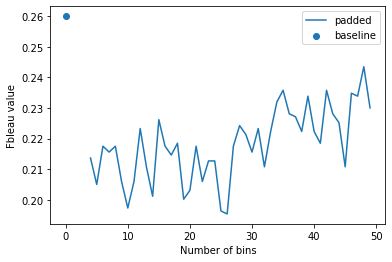

In [19]:
xs = []
ys = []

for f in fbleau_perfs:
    xs.append(f)
    ys.append(fbleau_perfs[f][0])

plt.scatter([0], [0.26], label="baseline")
plt.plot(xs, ys, label="padded")
plt.xlabel("Number of bins")
plt.ylabel("Fbleau value")
plt.legend()

In [29]:
# feature extraction

import numpy as np
import math
import sys
import random

def average(array):
    if array is None or len(array) == 0:
        return 0
    return np.average(array)

def array_to_fix_size(array, length, pad_with=0):
    if len(array) < length:
        array.extend([pad_with] * (length - len(array)))
    elif len(array) > length:
        array = array[:length]
    return array

def split_in_chunks(array, num_splits):
    avg = len(array) / float(num_splits)
    out = []
    last = 0.0
    while last < len(array):
        out.append(array[int(last): int(last + avg)])
        last += avg
    return out

def get_packet_inter_times(data):
    if len(data) == 0:
        return [0]
    times = [x[0] for x in data]
    result = []
    for elem, next_elem in zip(times, times[1:] + [times[0]]):
        result.append(next_elem - elem)
    return result[:-1]

def add_intertimes_stats(features, data, incoming, outgoing):
    # statistics about the inter-packet durations

    def add_stats(trace, prefix=''):
        if trace is not None and len(trace) > 0:
            features['intertime_'+prefix+'max'] = max(trace)
            features['intertime_'+prefix + 'avg'] = average(trace)
            features['intertime_'+prefix+'std'] = np.std(trace)
            features['intertime_'+prefix+'p75'] = np.percentile(trace, 75)
        else:
            features['intertime_'+prefix+'p25'] = 0
            features['intertime_'+prefix+'p50'] = 0
            features['intertime_'+prefix+'p75'] = 0
            features['intertime_'+prefix+'p100'] = 0

    incoming_intertimes = get_packet_inter_times(incoming)
    outgoing_intertimes = get_packet_inter_times(outgoing)
    all_intertimes = get_packet_inter_times(data)

    add_stats(incoming_intertimes, 'incoming_')
    add_stats(outgoing_intertimes, 'outgoing_')
    add_stats(all_intertimes, '')


def add_time_percentiles(features, data, incoming, outgoing):
    # percentiles about the times in which packets where sent/received

    def add_percentiles(trace, prefix=''):
        if trace is not None and len(trace) > 0:
            features['time_'+prefix+'p25'] = np.percentile(trace, 25)
            features['time_'+prefix+'p50'] = np.percentile(trace, 50)
            features['time_'+prefix+'p75'] = np.percentile(trace, 75)
            features['time_'+prefix+'p100'] = np.percentile(trace, 100)
        else:
            features['time_'+prefix+'p25'] = 0
            features['time_'+prefix+'p50'] = 0
            features['time_'+prefix+'p75'] = 0
            features['time_'+prefix+'p100'] = 0

    incoming_times = [x[0] for x in incoming]
    outgoing_times = [x[0] for x in outgoing]
    times = [x[0] for x in data]

    add_percentiles(incoming_times, 'incoming_')
    add_percentiles(outgoing_times, 'outgoing_')
    add_percentiles(times, '')

    features['times_sum'] = sum(times)


def add_counts_in_out_last_first_30(features, data):
    # counts (incoming, outgoing) packets in the (first, last) 30 packets

    # NB: these features don't make much sense for HARs

    first30 = data[:30]
    last30 = data[-30:]
    first30in = []
    first30out = []
    for p in first30:
        if p[1] > 0: 
            first30in.append(p)
        if p[2] >= 0:
            first30out.append(p)
    last30in = []
    last30out = []
    for p in last30:
        if p[1] > 0:
            last30in.append(p)
        if p[2] >= 0:
            last30out.append(p)

    features['f30_n_incoming'] = len(first30in)
    features['f30_n_outgoing'] = len(first30out)
    features['l30_n_incoming'] = len(last30in)
    features['l30_n_outgoing'] = len(last30out)


def add_outgoing_concentrations_stats(features, data):
    # concentration of outgoing packets in chunks of 20 packets

    chunks = [data[x: x + 20] for x in range(0, len(data), 20)]
    concentrations = []
    for item in chunks:
        c = 0
        for p in item:
            if p[2] >= 0: # outgoing packets
                c += 1
        concentrations.append(c)

    concentrations = array_to_fix_size(concentrations, 40)

    features['outgoing_concentrations_std'] = np.std(concentrations)
    features['outgoing_concentrations_mean'] = average(concentrations)
    features['outgoing_concentrations_p50'] = np.percentile(concentrations, 50)
    features['outgoing_concentrations_min'] = min(concentrations)
    features['outgoing_concentrations_max'] = max(concentrations)

    i = 0
    while i < len(concentrations):
        features['outgoing_concentrations_'+str(i)] = concentrations[i]
        i += 1

    # Same think, but for trace divided in 70 fixed chunks

    outgoing_concentrations_70 = [
        sum(x) for x in split_in_chunks(concentrations, 70)]

    i = 0
    while i < len(outgoing_concentrations_70):
        features['outgoing_concentrations_70_' +
                 str(i)] = outgoing_concentrations_70[i]
        i += 1

    features['outgoing_concentrations_70_sum'] = sum(
        outgoing_concentrations_70)


def add_delta_rates_stats(features, data):
    # Average number packets sent and received per second

    last_time = data[-1][1]
    last_second = math.ceil(last_time)

    count_per_sec = []
    for sec in range(1, int(last_second) + 1):
        count = 0
        for p in data:
            if p[0] <= sec: # p[0] is packet time
                count += 1
        count_per_sec.append(count)

    count_per_sec = array_to_fix_size(count_per_sec, 10)

    delta_count_per_sec = [0]  # first difference is 0
    i = 1
    while i < len(count_per_sec):
        diff = count_per_sec[i] - count_per_sec[i-1]
        delta_count_per_sec.append(diff)
        i += 1

    features['delta_rate_avg'] = average(delta_count_per_sec)
    features['delta_rate_std'] = np.std(delta_count_per_sec)
    features['delta_rate_p50'] = np.percentile(delta_count_per_sec, 50)
    features['delta_rate_min'] = min(delta_count_per_sec)
    features['delta_rate_max'] = max(delta_count_per_sec)

    i = 1
    while i < len(delta_count_per_sec):
        features['delta_rate_'+str(i)] = delta_count_per_sec[i]
        i += 1

    # Same thing, but trace divided in 20 fixed chunks

    delta_counts_20 = [sum(x)
                       for x in split_in_chunks(delta_count_per_sec, 20)]

    i = 0
    while i < len(delta_counts_20):
        features['delta_rates_20_'+str(i)] = delta_counts_20[i]
        i += 1

    features['delta_rates_20_sum'] = sum(delta_counts_20)


def extract_features(data, max_size=123):
    features = dict()


    if len(data) == 0:
        return array_to_fix_size([], max_size, pad_with=('*', 0))

    def quic_to_1(s):
        if s=='quic':
            return 1
        return 0

    outgoing = [pkt for pkt in data if pkt[1] > 0]
    incoming = [pkt for pkt in data if pkt[2] > 0]

    features['n_incoming'] = len(incoming)
    features['n_outgoing'] = len(outgoing)
    features['n_total'] = len(data)
    features['%_in'] = len(incoming) / float(len(data))
    features['%_out'] = len(outgoing) / float(len(data))
    
    features['bytes_incoming'] = sum([d[2] for d in incoming])
    features['bytes_outgoing'] = sum([d[1] for d in outgoing])
    features['bytes_total'] = features['bytes_incoming'] + features['bytes_outgoing']
    if features['bytes_total'] > 0:
        features['bytes_%_in'] = features['bytes_incoming'] / float(features['bytes_total'])
        features['bytes_%_out'] = features['bytes_outgoing'] / float(features['bytes_total'])
    else:
        features['bytes_%_in'] = 0
        features['bytes_%_out'] = 0

    add_intertimes_stats(features, data, incoming, outgoing)
    add_time_percentiles(features, data, incoming, outgoing)
    add_counts_in_out_last_first_30(features, data)

    add_delta_rates_stats(features, data)

    # added size features; TLS max is -16K +16k
    incoming_sizes = [x[2] for x in incoming]
    bins = np.linspace(0, 16*1024, 50)
    hist, bin_edges = np.histogram(incoming_sizes, bins=bins, density=False)

    i = 0
    while i < len(hist):
        features['hist_'+str(round(bin_edges[i]))] = hist[i]
        i += 1
    i = 0
    while i < len(hist):
        features['hist_'+str(round(bin_edges[i]))] = hist[i]
        i += 1

    # unmap feature dictionnary for padding
    tuples = [(k, v) for k, v in features.items()]

    features = array_to_fix_size(tuples, max_size, pad_with=('*', 0))

    return features

def trace_starts_at_time0(X):

    if len(X) == 0:
        return X

    t0 = X[0][0]
    i = 0
    while i<len(X):
        X[i][0] -= t0
        i += 1

    return X

def get_features(hars):
    result = dict(feature_names=None, feature=[], label=[])

    result = dict()
    result['feature_names'] = None
    result['features'] = [] #X
    result['labels'] = [] #y

    for i, url in enumerate(hars):
        samples = hars[url]
        empty_samples = [s for s in samples if len(samples[s]) == 0]

        if len(samples) < 20:
            print("Skipping", url, "only", len(samples), "samples")
            continue

        if len(empty_samples) > 5:
            print("Skipping", url, ",", len(empty_samples), "empty samples")
            continue

        for sample_id in samples:
            X = samples[sample_id]

            X = trace_starts_at_time0(X)
            f = extract_features(X)

            feature_names = [x[0] for x in f]
            feature_values = [x[1] for x in f]

            if result['feature_names'] is None:
                result['feature_names'] = feature_names
            result['features'].append(feature_values)
            result['labels'].append([url, sample_id])

    print("[feature_extract] Number of classes", len(set([y[0] for y in result['labels']])))
    print("[feature_extract] Number of features", len(result['features'][0]))
    print("[feature_extract] Number of samples", len(result['features']))
    print("[feature_extract] Number of labels", len(result['labels']))

    return result


In [20]:
last_size = 0
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)]['features'][:10]]
    med_cost_str = f"{round(med_cost)} B"
    if med_cost > 1024:
        med_cost_str = f"{round(med_cost/1024)} kB"
    print(f"steps: {len(cuts)}, mean extra cost/subresource {med_cost_str}, acc {acc}, features: {top_f}")

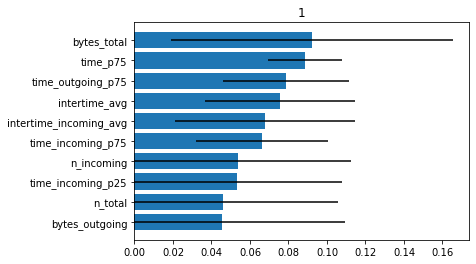

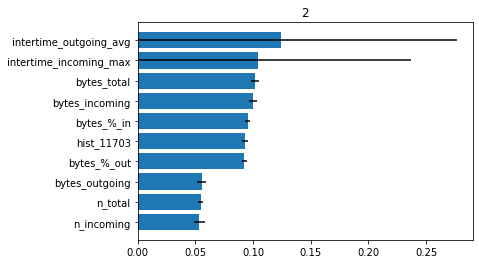

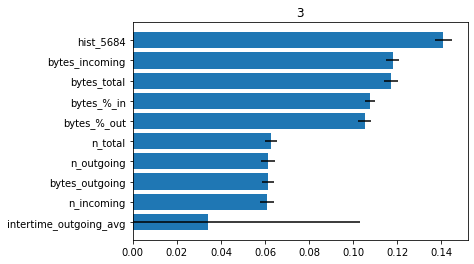

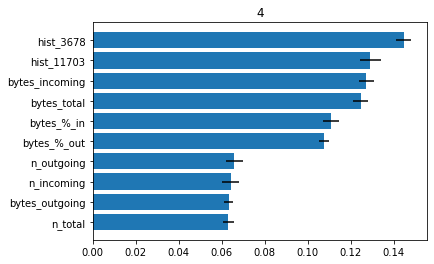

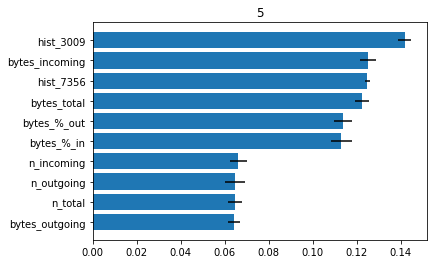

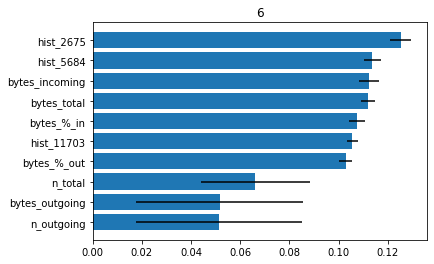

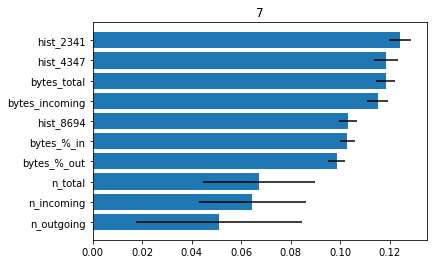

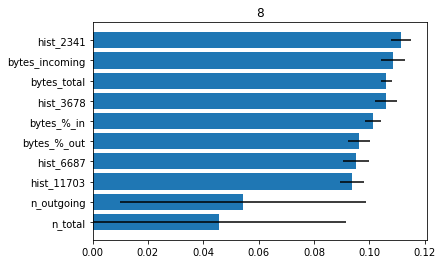

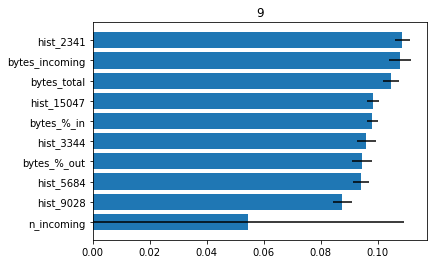

In [ ]:
def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()
    
    
last_size = 0
cuts_vs_med_cost_acc = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)]['features'][:10]]

    cuts_vs_med_cost_acc.append([len(cuts), med_cost, acc])

    # also plot for the first 15 results
    if len(cuts) < 10:
        plot_fi(clf_perfs[len(cuts)]['features'], title=len(cuts))


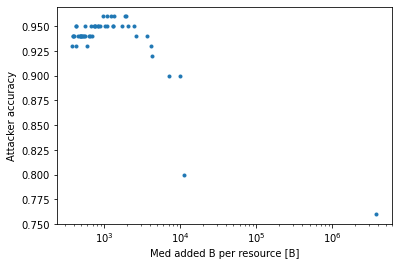

In [ ]:
len_cuts = [row[0] for row in cuts_vs_med_cost_acc]
med_costs = [row[1] for row in cuts_vs_med_cost_acc]
accs = [row[2] for row in cuts_vs_med_cost_acc]

plt.scatter(med_costs, accs, marker=".")
plt.ylabel("Attacker accuracy")
plt.xlabel("Med added B per resource [B]")
plt.xscale('log')

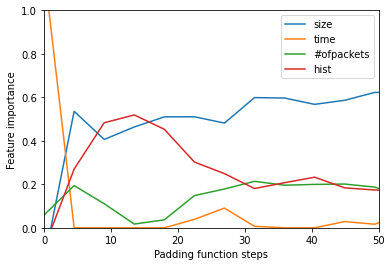

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

# understand how features evolve
def find_importance(features_and_importance, feature_name):
    for feature, importance, _ in features_and_importance:
        if feature == feature_name:
            return importance

    return 0

def sum_all_matching(features_and_importance, keyword):
    su = 0
    for feature, importance, _ in features_and_importance:
        if keyword in feature:
            su += importance

    return su

tuples = []
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue

    features = clf_perfs[len(cuts)]['features']
    #print(len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist"))
    tuples.append([len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist")])

def smooth(xs, ys, label=""):
    xnew = np.linspace(0, 220)
    spl = make_interp_spline(xs, ys, k=1)  # type: BSpline
    ys_smooth = spl(xnew)
    plt.plot(xnew, ys_smooth, label=label)

xs = [t[0] for t in tuples]
ys1 = [t[1] for t in tuples]
ys2 = [t[2] for t in tuples]
ys3 = [t[3] for t in tuples]
ys4 = [t[4] for t in tuples]

plt.subplot(1, 1, 1)
smooth(xs, ys1, label="size")
smooth(xs, ys2, label="time")
smooth(xs, ys3, label="#ofpackets")
smooth(xs, ys4, label="hist")


plt.xlabel("Padding function steps")
plt.ylabel("Feature importance")
plt.legend(loc='upper right')
plt.ylim([0,1])
plt.xlim([0, 50])
plt.show()
    

In [ ]:
#print(padding_functions)
#print(clf_perfs)

to_plot = []
for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perfs[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perfs[len(cuts)]['features'][:3]]
 
    to_plot.append([len(cuts), med_cost, acc])

len_cuts = [row[0] for row in to_plot]
med_costs = [row[1] for row in to_plot]
accs = [row[2] for row in to_plot]

plt.plot(len_cuts, accs, marker=".")
plt.ylabel("Attacker accuracy")
plt.xlabel("Padding function steps")
plt.show()
plt.scatter(len_cuts, med_costs, marker=".")
plt.ylim([1,5000])
plt.ylabel("Mean cost/subrequest [kB]")
plt.xlabel("Padding function steps")
plt.show()

NameError: name 'padding_functions' is not defined

In [ ]:
if False:
    data_short = dict()
    data_short['x'] = data['online-slots.co']
    res = get_features(data_short)
    feature_names = res['feature_names']
    print(feature_names)

feature_type = dict()
feature_type["n_incoming"] = "aggregate"
feature_type["n_outgoing"] = "aggregate"
feature_type["n_total"] = "aggregate"
feature_type["%_in"] = "aggregate"
feature_type["%_out"] = "aggregate"
feature_type["bytes_incoming"] = "aggregate"
feature_type["bytes_outgoing"] = "aggregate"
feature_type["bytes_total"] = "aggregate"
feature_type["bytes_%_in"] = "aggregate"
feature_type["bytes_%_out"] = "aggregate"
feature_type["times_sum"] = "aggregate"
feature_type["time_p25"] = "aggregate"
feature_type["time_p50"] = "aggregate"
feature_type["time_p75"] = "aggregate"
feature_type["time_p100"] = "aggregate"
feature_type["time_incoming_p25"] = "aggregate"
feature_type["time_incoming_p50"] = "aggregate"
feature_type["time_incoming_p75"] = "aggregate"
feature_type["time_incoming_p100"] = "aggregate"
feature_type["time_outgoing_p25"] = "aggregate"
feature_type["time_outgoing_p50"] = "aggregate"
feature_type["time_outgoing_p75"] = "aggregate"
feature_type["time_outgoing_p100"] = "aggregate"

feature_type["intertime_incoming_max"] = "local"
feature_type["intertime_incoming_avg"] = "local"
feature_type["intertime_incoming_std"] = "local"
feature_type["intertime_incoming_p75"] = "local"
feature_type["intertime_outgoing_max"] = "local"
feature_type["intertime_outgoing_avg"] = "local"
feature_type["intertime_outgoing_std"] = "local"
feature_type["intertime_outgoing_p75"] = "local"
feature_type["intertime_max"] = "local"
feature_type["intertime_avg"] = "local"
feature_type["intertime_std"] = "local"
feature_type["intertime_p75"] = "local"

feature_type["f30_n_incoming"] = "local"
feature_type["f30_n_outgoing"] = "local"
feature_type["l30_n_incoming"] = "local"
feature_type["l30_n_outgoing"] = "local"

feature_type["delta_rate_avg"] = "local"
feature_type["delta_rate_std"] = "local"
feature_type["delta_rate_p50"] = "local"
feature_type["delta_rate_min"] = "local"
feature_type["delta_rate_max"] = "local"
feature_type["delta_rate_1"] = "local"
feature_type["delta_rate_2"] = "local"
feature_type["delta_rate_3"] = "local"
feature_type["delta_rate_4"] = "local"
feature_type["delta_rate_5"] = "local"
feature_type["delta_rate_6"] = "local"
feature_type["delta_rate_7"] = "local"
feature_type["delta_rate_8"] = "local"
feature_type["delta_rate_9"] = "local"
feature_type["delta_rates_20_0"] = "local"
feature_type["delta_rates_20_1"] = "local"
feature_type["delta_rates_20_2"] = "local"
feature_type["delta_rates_20_3"] = "local"
feature_type["delta_rates_20_4"] = "local"
feature_type["delta_rates_20_5"] = "local"
feature_type["delta_rates_20_6"] = "local"
feature_type["delta_rates_20_7"] = "local"
feature_type["delta_rates_20_8"] = "local"
feature_type["delta_rates_20_9"] = "local"
feature_type["delta_rates_20_10"] = "local"
feature_type["delta_rates_20_11"] = "local"
feature_type["delta_rates_20_12"] = "local"
feature_type["delta_rates_20_13"] = "local"
feature_type["delta_rates_20_14"] = "local"
feature_type["delta_rates_20_15"] = "local"
feature_type["delta_rates_20_16"] = "local"
feature_type["delta_rates_20_17"] = "local"
feature_type["delta_rates_20_18"] = "local"
feature_type["delta_rates_20_19"] = "local"
feature_type["delta_rates_20_sum"] = "local"
feature_type["hist_0"] = "local"
feature_type["hist_334"] = "local"
feature_type["hist_669"] = "local"
feature_type["hist_1003"] = "local"
feature_type["hist_1337"] = "local"
feature_type["hist_1672"] = "local"
feature_type["hist_2006"] = "local"
feature_type["hist_2341"] = "local"
feature_type["hist_2675"] = "local"
feature_type["hist_3009"] = "local"
feature_type["hist_3344"] = "local"
feature_type["hist_3678"] = "local"
feature_type["hist_4012"] = "local"
feature_type["hist_4347"] = "local"
feature_type["hist_4681"] = "local"
feature_type["hist_5016"] = "local"
feature_type["hist_5350"] = "local"
feature_type["hist_5684"] = "local"
feature_type["hist_6019"] = "local"
feature_type["hist_6353"] = "local"
feature_type["hist_6687"] = "local"
feature_type["hist_7022"] = "local"
feature_type["hist_7356"] = "local"
feature_type["hist_7690"] = "local"
feature_type["hist_8025"] = "local"
feature_type["hist_8359"] = "local"
feature_type["hist_8694"] = "local"
feature_type["hist_9028"] = "local"
feature_type["hist_9362"] = "local"
feature_type["hist_9697"] = "local"
feature_type["hist_10031"] = "local"
feature_type["hist_10365"] = "local"
feature_type["hist_10700"] = "local"
feature_type["hist_11034"] = "local"
feature_type["hist_11368"] = "local"
feature_type["hist_11703"] = "local"
feature_type["hist_12037"] = "local"
feature_type["hist_12372"] = "local"
feature_type["hist_12706"] = "local"
feature_type["hist_13040"] = "local"
feature_type["hist_13375"] = "local"
feature_type["hist_13709"] = "local"
feature_type["hist_14043"] = "local"
feature_type["hist_14378"] = "local"
feature_type["hist_14712"] = "local"
feature_type["hist_15047"] = "local"
feature_type["hist_15381"] = "local"
feature_type["hist_15715"] = "local"
feature_type["hist_16050"] = "local"

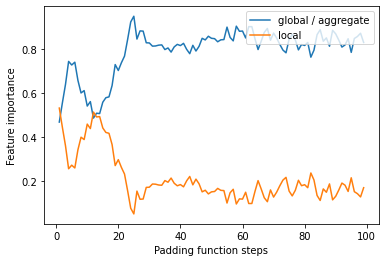

In [ ]:
# understand how features evolve
def find_importance(features_and_importance, feature_name):
    for feature, importance, _ in features_and_importance:
        if feature == feature_name:
            return importance

    return 0

def sum_all_matching2(features_and_importance, keyword):
    su = 0
    for feature, importance, _ in features_and_importance:
        if feature_type[feature] == keyword:
            su += importance

    return su

tuples = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perfs: # if the attack was not run, skip
        continue

    features = clf_perfs[len(cuts)]['features']
    tuples.append([len(cuts), sum_all_matching2(features, "aggregate"), sum_all_matching2(features, "local")])

xs = [t[0] for t in tuples]
ys1 = [t[1] for t in tuples]
ys2 = [t[2] for t in tuples]

plt.subplot(1, 1, 1)
plt.plot(xs, ys1, label="global / aggregate")
plt.plot(xs, ys2, label="local")
plt.xlabel("Padding function steps")
plt.ylabel("Feature importance")
plt.legend(loc='upper right')
plt.show()
    

In [10]:
# Sandra's blobbed HARs:

data_blobbed = np.load('datasets/blobbed-hars.npy', allow_pickle=True).item()
data_blobbed_old = toOldHARFormat(data_blobbed)
urls = [url for url in data_blobbed]

features = get_features(data_blobbed_old)
clf = rf_with_rfe(features)
print(clf)

Skipping sahafah24.com only 19 samples
Skipping ragazzeconlavaligia.com , 19 empty samples
Skipping faktabmr.com only 14 samples
Skipping miglianicocalcio.net only 14 samples
Skipping www.cscpro.org only 14 samples
Skipping levitra100pudoff.com only 14 samples
Skipping megagroup.ir only 13 samples
Skipping educortex.in only 12 samples
Skipping arthurmurray.com only 13 samples
Skipping hitburada.com only 13 samples
Skipping odlotw.blogspot.com only 13 samples
Skipping funakoshikarateaustralia.com.au only 13 samples
Skipping whoisdog.com only 13 samples
Skipping kk-vine.at only 13 samples
Skipping myegypthost.com only 13 samples
Skipping matchingimages.com only 13 samples
Skipping onlinecasino002.com only 10 samples
Skipping kayseriolaylari.com only 9 samples
Skipping hpsconline.in only 1 samples
[feature_extract] Number of classes 114
[feature_extract] Number of features 123
[feature_extract] Number of samples 3856
[feature_extract] Number of labels 3856
Number of classes 114
Number of 

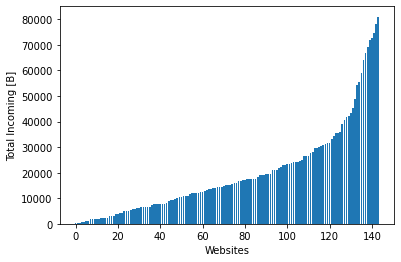

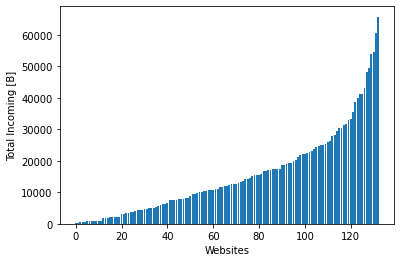

In [13]:
# total incoming size
incoming_bytes = []
incoming_bytes_per_website = dict()
incoming_bytes_per_website_noprotection = dict()
max_query=0

for url in data_blobbed_old:
    outgoing_bytes_this_website = []

    for sample in data_blobbed_old[url]:
        outgoing_bytes_this_sample = 0
        for request in data_blobbed_old[url][sample]:
            t, out, inc = request
            outgoing_bytes_this_sample += out
            if out > max_query:
                max_query = out
            incoming_bytes.append(inc)

        outgoing_bytes_this_website.append(outgoing_bytes_this_sample)

    if len(outgoing_bytes_this_website) > 0:
        incoming_bytes_per_website[url] = [np.mean(outgoing_bytes_this_website), np.std(outgoing_bytes_this_website)]
tuples = list(incoming_bytes_per_website.items())
tuples.sort(key=lambda row: row[1])

xs2 = [t[0][:3] for t in tuples]
ys2 = [int(t[1][0]) for t in tuples]

plt.bar(np.arange(len(ys[:-1])), ys[:-1])
plt.xlabel('Websites')
plt.ylabel('Total Incoming [B]')
plt.show()

plt.bar(np.arange(len(ys2)), ys2)
plt.xlabel('Websites')
plt.ylabel('Total Incoming [B]')
plt.show()